In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import median_filter

def sobel_filter(image):
    """Apply Sobel filtering to the input image to enhance edges."""
    # Define Sobel kernels for horizontal and vertical gradients
    sobel_x = np.array([[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]])

    sobel_y = np.array([[-1, -2, -1], 
                        [0, 0, 0], 
                        [1, 2, 1]])

    # Image dimensions
    height, width = image.shape
    sobel_filtered_image = np.zeros_like(image, dtype=np.float32)

    # Apply Sobel filter
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            # Extract the 3x3 region
            region = image[y - 1:y + 2, x - 1:x + 2]
            
            # Calculate gradient magnitudes
            gx = np.sum(sobel_x * region)
            gy = np.sum(sobel_y * region)
            
            # Calculate magnitude of gradient
            sobel_filtered_image[y, x] = np.sqrt(gx ** 2 + gy ** 2)

    # Normalize the result to range [0, 255]
    sobel_filtered_image = (sobel_filtered_image / np.max(sobel_filtered_image)) * 255
    return sobel_filtered_image

def ssd(block1, block2):
    """Compute the Sum of Squared Differences (SSD) between two blocks."""
    return np.sum((block1 - block2) ** 2)

def sad(block1, block2):
    """Compute the Sum of Absolute Differences (SAD) between two blocks."""
    return np.sum(np.abs(block1 - block2))

def compute_disparity(source_img, target_img, direction="left", block_size=5, max_disparity_search=64, cost_function="ssd"):
    """Compute the disparity map using block matching."""
    height, width = source_img.shape
    disparity_map = np.zeros((height, width), dtype=np.float32)
    
    half_block = block_size // 2
    
    # Select cost function
    cost_func = ssd if cost_function == "ssd" else sad
    
    for y in range(half_block, height - half_block):
        for x in range(half_block, width - half_block):
            best_match = float('inf')
            best_disparity = 0
            
            source_block = source_img[y - half_block:y + half_block + 1, x - half_block:x + half_block + 1]
            
            # Search range based on direction
            if direction == "left":
                start = max(half_block, x - max_disparity_search)
                end = x
            else:
                start = x
                end = min(width - half_block, x + max_disparity_search)
            
            for d in range(start, end):
                target_block = target_img[y - half_block:y + half_block + 1, d - half_block:d + half_block + 1]
                
                cost = cost_func(source_block, target_block)
                
                if cost < best_match:
                    best_match = cost
                    best_disparity = np.abs(x - d)
            
            disparity_map[y, x] = best_disparity
            
    return disparity_map

def left_right_consistency_check(left_disparity, right_disparity, threshold=1):
    """Check for left-right consistency and mark inconsistencies as invalid."""
    height, width = left_disparity.shape
    final_disparity = np.copy(left_disparity)
    
    for y in range(height):
        for x in range(width):
            d = left_disparity[y, x]
            if x - int(d) >= 0 and abs(d - right_disparity[y, x - int(d)]) > threshold:
                final_disparity[y, x] = 0  # Mark as invalid
                
    return final_disparity

def preprocess(img):
    """Preprocess the image by normalizing it to range 0-255."""
    normalized_image =  (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    filtered_image = sobel_filter(normalized_image)
    return filtered_image

def disparity_map(left_img, right_img, block_size=5, max_disparity_search=64, cost_function="ssd"):
    """Generate the final disparity map using left-right consistency check."""
    left_img, right_img = preprocess(left_img), preprocess(right_img)
    
    left_disparity = compute_disparity(left_img, right_img, "left", block_size, max_disparity_search, cost_function)
    right_disparity = compute_disparity(right_img, left_img, "right", block_size, max_disparity_search, cost_function)
    
    final_disparity = left_right_consistency_check(left_disparity, right_disparity)
    final_disparity = median_filter(final_disparity, size=3)
    return final_disparity

def load_image(image_path):
    """Load a JPEG image and convert it to a grayscale numpy array."""
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    return np.array(image, dtype=np.float32)

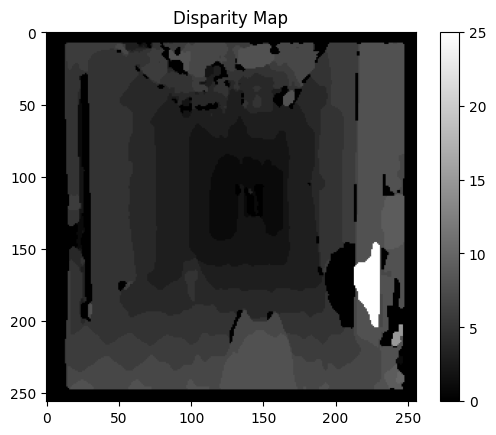

In [17]:
left_img = load_image("images/corridorl.jpg")
right_img = load_image("images/corridorr.jpg")

disparity = disparity_map(left_img, right_img, block_size=16, max_disparity_search=64, cost_function="sad")

plt.imshow(disparity, cmap='gray')
plt.colorbar()
plt.title("Disparity Map")
plt.show()

In [21]:
from typing import List

def plot_param_matrix(block_sizes: List[int], search_widths: List[int], left_img_path: str, right_img_path: str, cost_function="sad", save_fig=None):
    """Plots a matrix of disparity maps for different block sizes and max_disparity_search values."""
    # Load the left and right images
    left_img = load_image(left_img_path)
    right_img = load_image(right_img_path)
    
    # Number of rows and columns for subplots
    rows = len(block_sizes)
    cols = len(search_widths)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    fig.suptitle('Disparity Maps for Different Block Sizes and Search Widths', fontsize=16)
    
    for i, block_size in enumerate(block_sizes):
        for j, max_disparity_search in enumerate(search_widths):
            # Compute the disparity map for the current parameters
            disparity = disparity_map(left_img, right_img, block_size=block_size, max_disparity_search=max_disparity_search, cost_function=cost_function)
            
            # Plot the disparity map in the corresponding subplot
            ax = axes[i, j]
            im = ax.imshow(disparity, cmap='gray')
            ax.set_title(f"Block Size: {block_size}, Search Width: {max_disparity_search}")
            ax.axis('off')
    
    # Adjust layout and add colorbar
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
    fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    if save_fig:
        fig.savefig(save_fig)
    plt.show()

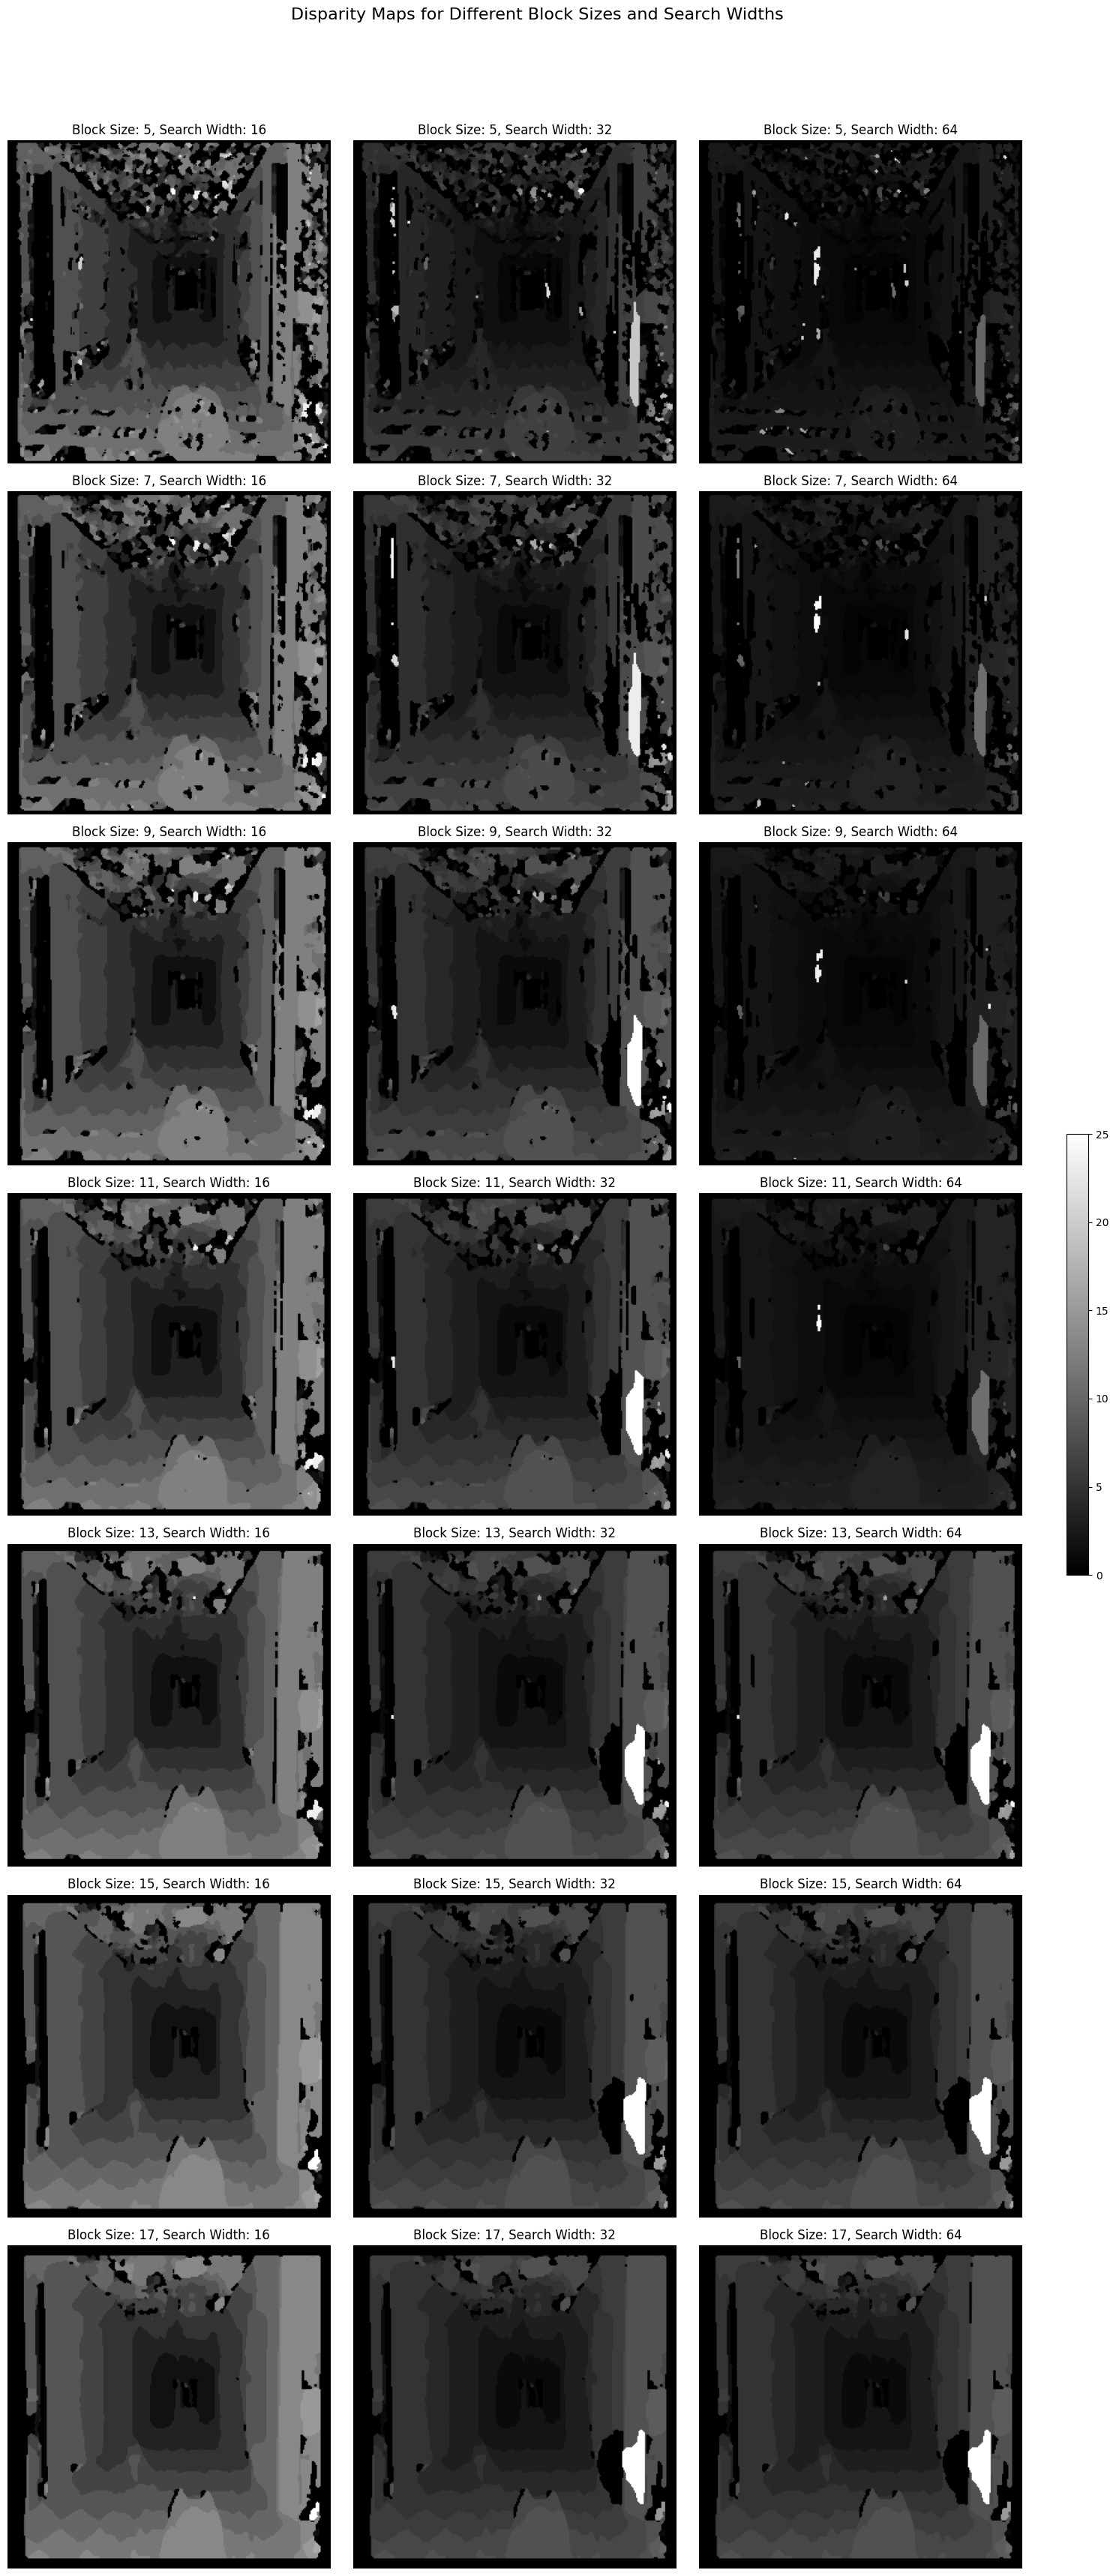

In [22]:
plot_param_matrix(
    block_sizes=list(range(5, 19, 2)),
    search_widths=[16, 32, 64],
    left_img_path="images/corridorl.jpg",
    right_img_path="images/corridorr.jpg",
    cost_function="sad",
    save_fig="param_matrix_corridor.png"    
)

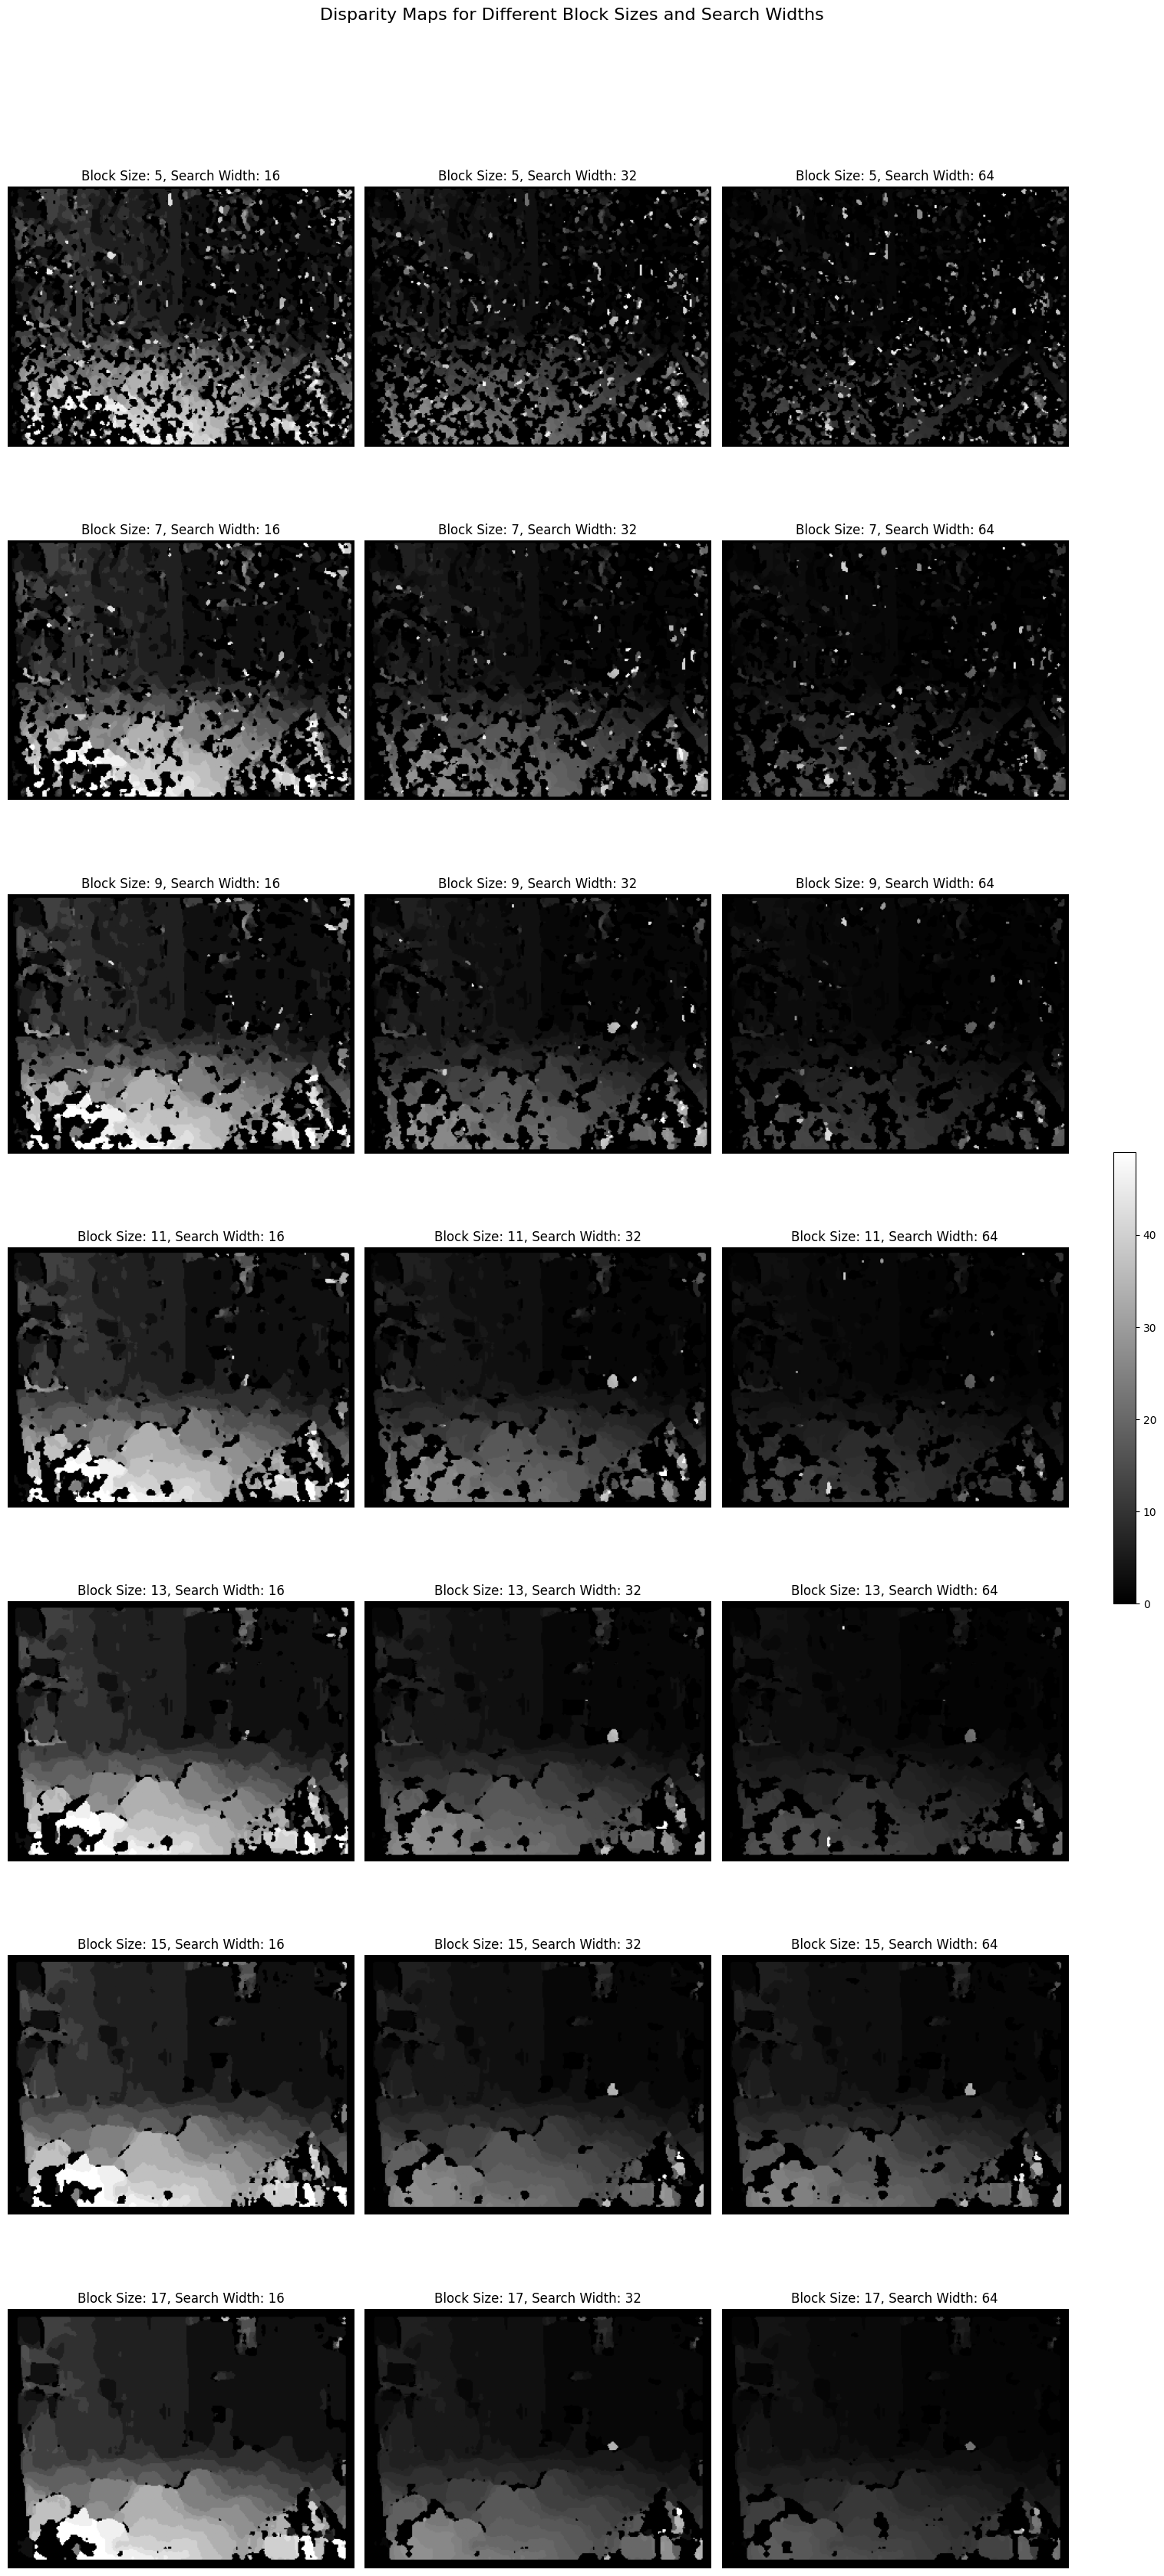

In [23]:
plot_param_matrix(
    block_sizes=list(range(5, 19, 2)),
    search_widths=[16, 32, 64],
    left_img_path="images/triclopsi2l.jpg",
    right_img_path="images/triclopsi2r.jpg",
    cost_function="sad",
    save_fig="param_matrix_triclops.png"   
)